In [6]:
id_ = 'Deng_Liu_LUAD_2024'
# id = 'Lambrechts_2018_LUAD_6149v1'
backup_dir = '/root/datos/maestria/netopaas/luca_explore/surgeries'
luca_dir = '/root/datos/maestria/netopaas/lung_scRNA/LUCA_model/'

In [7]:
import os
import gdown

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch
import scanpy as sc
import scarches as sca
from scarches.dataset.trvae.data_handling import remove_sparsity

2024-08-20 03:39:55.259246: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-20 03:39:55.259514: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-20 03:39:55.336406: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-20 03:39:57.054431: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
 captum (see https://github.com/pytorch/captum).


In [8]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

In [9]:
# Important to have the same sample column in model and adata
condition_key = 'dataset'
cell_type_key = 'cell_type_tumor'

ref_path = f'{luca_dir}/hvg_integrated_scvi_scanvi_tumor_model_3layers/'
# target_adata = sc.read_h5ad(f'{backup_dir}/filtered_{id_}.h5ad')

### Count cells and samples

In [39]:
adata.obs.dataset.value_counts()

Chen_Zhang_2020                     93035
Wu_Zhou_2021                        58981
UKIM-V-2                            54365
Kim_Lee_2020                        47939
He_Fan_2021                         44614
Lambrechts_Thienpont_2018_6149v2    29280
Zilionis_Klein_2019                 25652
Goveia_Carmeliet_2020               21186
Lambrechts_Thienpont_2018_6653      14369
Laughney_Massague_2020              12657
UKIM-V                              11401
Maynard_Bivona_2020                  7098
Lambrechts_Thienpont_2018_6149v1     3243
Name: dataset, dtype: int64

In [37]:
adata.obs.groupby(['dataset','sample']).size()

dataset              sample                  
Chen_Zhang_2020      Chen_Zhang_2020_NSCLC-1     1818
                     Chen_Zhang_2020_NSCLC-2     3886
                     Chen_Zhang_2020_NSCLC-3     7196
                     Chen_Zhang_2020_NSCLC-4     4039
                     Chen_Zhang_2020_NSCLC-5     8170
                                                 ... 
Zilionis_Klein_2019  Zilionis_Klein_2019_p5t2    1549
                     Zilionis_Klein_2019_p6t1    2056
                     Zilionis_Klein_2019_p6t2    1840
                     Zilionis_Klein_2019_p7t1    1828
                     Zilionis_Klein_2019_p7t2    1782
Length: 2080, dtype: int64

In [18]:
a = pd.DataFrame(a)

In [32]:
a = a.reset_index()

In [36]:
a[a[0] != 0].dataset.value_counts()

Wu_Zhou_2021                        42
Zilionis_Klein_2019                 18
Kim_Lee_2020                        15
UKIM-V-2                            14
Maynard_Bivona_2020                 13
Chen_Zhang_2020                     11
Lambrechts_Thienpont_2018_6149v2     9
Lambrechts_Thienpont_2018_6653       9
Laughney_Massague_2020               8
Goveia_Carmeliet_2020                7
Lambrechts_Thienpont_2018_6149v1     6
He_Fan_2021                          5
UKIM-V                               3
Name: dataset, dtype: int64

In [41]:
source_adata = sc.read_h5ad('/root/datos/maestria/netopaas/source.h5ad')

In [44]:
model = sca.models.SCANVI.load('/root/datos/maestria/netopaas/lung_scRNA/LUCA_model/hvg_integrated_scvi_scanvi_tumor_model_anvi3layers/',adata=source_adata)

INFO     File                                                                                                      
         /root/datos/maestria/netopaas/lung_scRNA/LUCA_model/hvg_integrated_scvi_scanvi_tumor_model_anvi3layers/mod
         el.pt already downloaded                                                                                  


<frozen abc>:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.



In [45]:
model

ScanVI Model with the following params: 
unlabeled_category: Unknown, n_hidden: 256, n_latent: 20, n_layers: 3, dropout_rate: 0.1, dispersion: gene, 
gene_likelihood: nb
Training status: Trained
Model's adata is minified?: False

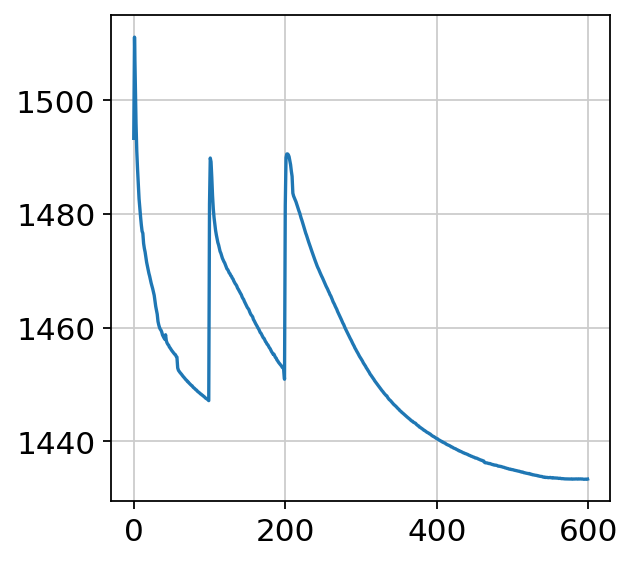

In [48]:
plt.plot(model.history['elbo_train'])

## Convert to ENSEMBL id

In [5]:
import rpy2.rinterface_lib.callbacks
import logging
from rpy2.robjects import pandas2ri
import rpy2.robjects as robjects

# Set the graphics device
robjects.r('options(bitmapType="cairo")')
import anndata2ri

# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

/tmp/ipykernel_88/4289007373.py:16: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


In [6]:
adata = target_adata
gene_names = list(adata.var.index)

In [7]:
%%R -i gene_names -o ens38 -o ens37
# extids <- c("AL627309.1","MIR1302-2HG","ENSG00000243485")
library(biomaRt)

extids <- gene_names

ensembl38 <- useEnsembl(biomart = "genes", dataset = "hsapiens_gene_ensembl",
                        mirror = "useast")
ensembl37 <- useEnsembl(biomart = "genes", dataset = "hsapiens_gene_ensembl",
                        mirror = "useast", version='GRCh37')

ens38 <- getBM(attributes = c('ensembl_gene_id','external_gene_name'),
      filters = 'external_gene_name',
      values = extids, 
      mart = ensembl38)
ens37 <- getBM(attributes = c('ensembl_gene_id','external_gene_name'),
      filters = 'external_gene_name',
      values = extids, 
      mart = ensembl37)

In addition: Warning message:
version or GRCh arguments cannot be used together with the mirror argument.
We will ignore the mirror argument and connect to the main Ensembl site. 


In [8]:
adata.var['symbol'] = adata.var.index

miau = pd.merge(adata.var.loc[:,['symbol']], ens37, left_on='symbol', right_on='external_gene_name', how='left')
miau = miau.drop_duplicates('symbol')
miau.index = miau.symbol
adata.var['ensembl_gene_id1'] = miau['ensembl_gene_id'].copy()

miau = pd.merge(adata.var.loc[:,['symbol']], ens38, left_on='symbol', right_on='external_gene_name', how='left')
miau = miau.drop_duplicates('symbol')
miau.index = miau.symbol
adata.var['ensembl_gene_id2'] = miau['ensembl_gene_id'].copy()

adata.var['ensembl_gene_id'] = adata.var['ensembl_gene_id2'].combine_first(adata.var['ensembl_gene_id1'])

In [9]:
adata.var['ensembl_gene_id1'].isna().sum()

12790

In [10]:
adata.var['ensembl_gene_id2'].isna().sum()

11583

In [11]:
ensembl = adata.var.loc[:,['symbol', 'ensembl_gene_id']]
ensembl.to_csv(f'{backup_dir}/{id_.split("_")[0]}_ensembl.csv')
# ensembl = pd.read_csv(f'{backup_dir}/{id_.split('_')[0]}_ensembl.csv', index_col=0)

In [12]:
target_adata.var.index = target_adata.var['ensembl_gene_id']

## Perform surgery on reference model and train on query dataset without cell type labels

In [45]:
# target_adata.obs[cell_type_key] = scanvae.unlabeled_category_
target_adata.obs[condition_key] = id_.split("_")[0]
target_adata.obs[cell_type_key] = 'Unknown'
target_adata

AnnData object with n_obs × n_vars = 421711 × 23634
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'assigned_cell_type', 'stage', 'Ecotype', 'ecoRecovery', 'Patient Number', 'Group', 'Sex', 'Age （years）', 'Current or former smoking', 'Cancer history', 'Tumor location', 'Tumor size（cm）', 'Pathology', 'Histological subtype', 'T stage', 'N stage', 'M stage', 'Pathological stage', 'dataset', 'cell_type_tumor'
    var: 'features', 'symbol', 'ensembl_gene_id1', 'ensembl_gene_id2', 'ensembl_gene_id'
    obsm: 'X_tsne', 'X_umap'
    layers: 'data'

Lots of things  to make sure indices dont interfere

In [14]:
target_adata.obs.index = id_.split('_')[0] + target_adata.obs.index.astype('string')
target_adata.obs_names_make_unique()

In [15]:
target_adata.obs_names.duplicated().sum()

0

In [16]:
target_adata = target_adata[:, target_adata.var.ensembl_gene_id.notna()]
target_adata.var.index = target_adata.var.index.astype('string')

In [18]:
target_adata.var_names_make_unique()

In [38]:
adata_query = sca.models.SCANVI.prepare_query_anndata(
    adata = target_adata,
    # return_reference_var_names=True,
    reference_model = ref_path,
    inplace=False)

INFO     File                                                                                                      
         /root/datos/maestria/netopaas/lung_scRNA/LUCA_model//hvg_integrated_scvi_scanvi_tumor_model_3layers/model.
         pt already downloaded                                                                                     
INFO     Found 93.28769410586074% reference vars in query data.                                                    


KeyboardInterrupt: 

### Load adata_query

In [35]:
for col in adata_query.obs.columns:
    if pd.api.types.is_categorical_dtype(adata_query.obs[col]):
        adata_query.obs[col] = adata_query.obs[col].astype('str')

adata_query.obs.index = adata_query.obs.index.astype('object')

In [36]:
# adata_query.write_h5ad(f'{backup_dir}/query_{id_}.h5ad')
adata_query = sc.read_h5ad(f'{backup_dir}/query_{id_}.h5ad')

In [57]:
ref_path='/root/datos/maestria/netopaas/lung_scRNA/LUCA_model//hvg_integrated_scvi_scanvi_tumor_model_3layers/'
id_='Deng_Liu_LUAD_2024'
backup_dir='/root/datos/maestria/netopaas/luca_explore/surgeries'

'/root/datos/maestria/netopaas/lung_scRNA/LUCA_model//hvg_integrated_scvi_scanvi_tumor_model_3layers/'

In [41]:
adata_query.obs['sample'] = 'Unknown'

In [49]:
import scvi

scvi.settings.batch_size = 1024
scvi.settings.num_workers = 40
model = sca.models.SCANVI.load_query_data(
    adata_query,
    ref_path,
    freeze_dropout = True,
)

INFO     File                                                                                                      
         /root/datos/maestria/netopaas/lung_scRNA/LUCA_model//hvg_integrated_scvi_scanvi_tumor_model_3layers/model.
         pt already downloaded                                                                                     


In [49]:
import scvi

scvi.settings.batch_size = 1024
scvi.settings.num_workers = 40
model = sca.models.SCANVI.load_query_data(
    adata_query,
    ref_path,
    freeze_dropout = True,
)

INFO     File                                                                                                      
         /root/datos/maestria/netopaas/lung_scRNA/LUCA_model//hvg_integrated_scvi_scanvi_tumor_model_3layers/model.
         pt already downloaded                                                                                     


In [52]:
import scvi
scvi.train.Trainer
scvi.train.SemiSupervisedTrainingPlan

scvi.train._trainer.Trainer

In [54]:
early_stopping_kwargs_surgery = {
    "early_stopping_monitor": "elbo_train",
    "early_stopping_patience": 10,
    "early_stopping_min_delta": 0.01,
}
# This very importanto for actual covnergence... we have seen we tend to hit local minima and this helps i navoiding but only once...  a peridic approach would ve good
plan_kwargs= {"weight_decay": 0.0,
    "reduce_lr_on_plateau": True,
    "lr_patience": 8,
    "lr_factor": 0.1,
}


model.train(
    max_epochs=400,
    check_val_every_n_epoch=10,
    batch_size=128,  # Increasing batch size uses more gpu and reduces traingint time a lot, but may increase convergence time and be lesse generalizable
    early_stopping=early_stopping_kwargs_surgery,
    plan_kwargs=plan_kwargs
)

INFO     Training for 300 epochs.                                                                                  


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Epoch 1/300:   0%|                                                                                                                                                                         | 0/300 [00:00<?, ?it/s]

/usr/local/lib/python3.11/site-packages/lightning/pytorch/trainer/call.py:53: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [69]:
# model.save(f'{backup_dir}/{id_.split[0]}2', overwrite=True)
# adata_query.obs['sample'] = adata_query.obs['orig.ident']
model = sca.models.SCANVI.load(f'{backup_dir}/Deng3', adata_query)

INFO     File /root/datos/maestria/netopaas/luca_explore/surgeries/Deng3/model.pt already downloaded               


## Inspect Predictions

In [70]:
query_latent = sc.AnnData(model.get_latent_representation())
query_latent.obs['cell_type'] = adata_query.obs[cell_type_key].tolist()
query_latent.obs['batch'] = adata_query.obs[condition_key].tolist()

<frozen abc>:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.



/usr/local/lib/python3.11/site-packages/pynndescent/pynndescent_.py:346: NumbaPendingDeprecationWarning: Code using Numba extension API maybe depending on 'old_style' error-capturing, which is deprecated and will be replaced by 'new_style' in a future release. See details at https://numba.readthedocs.io/en/latest/reference/deprecation.html#deprecation-of-old-style-numba-captured-errors
Exception origin:
  File "/usr/local/lib/python3.11/site-packages/numba/core/types/functions.py", line 486, in __getnewargs__
    raise ReferenceError("underlying object has vanished")

  init_rp_tree(data, dist, current_graph, leaf_array)
/usr/local/lib/python3.11/site-packages/pynndescent/pynndescent_.py:348: NumbaPendingDeprecationWarning: Code using Numba extension API maybe depending on 'old_style' error-capturing, which is deprecated and will be replaced by 'new_style' in a future release. See details at https://numba.readthedocs.io/en/latest/reference/deprecation.html#deprecation-of-old-style-numb

<Figure size 320x320 with 0 Axes>

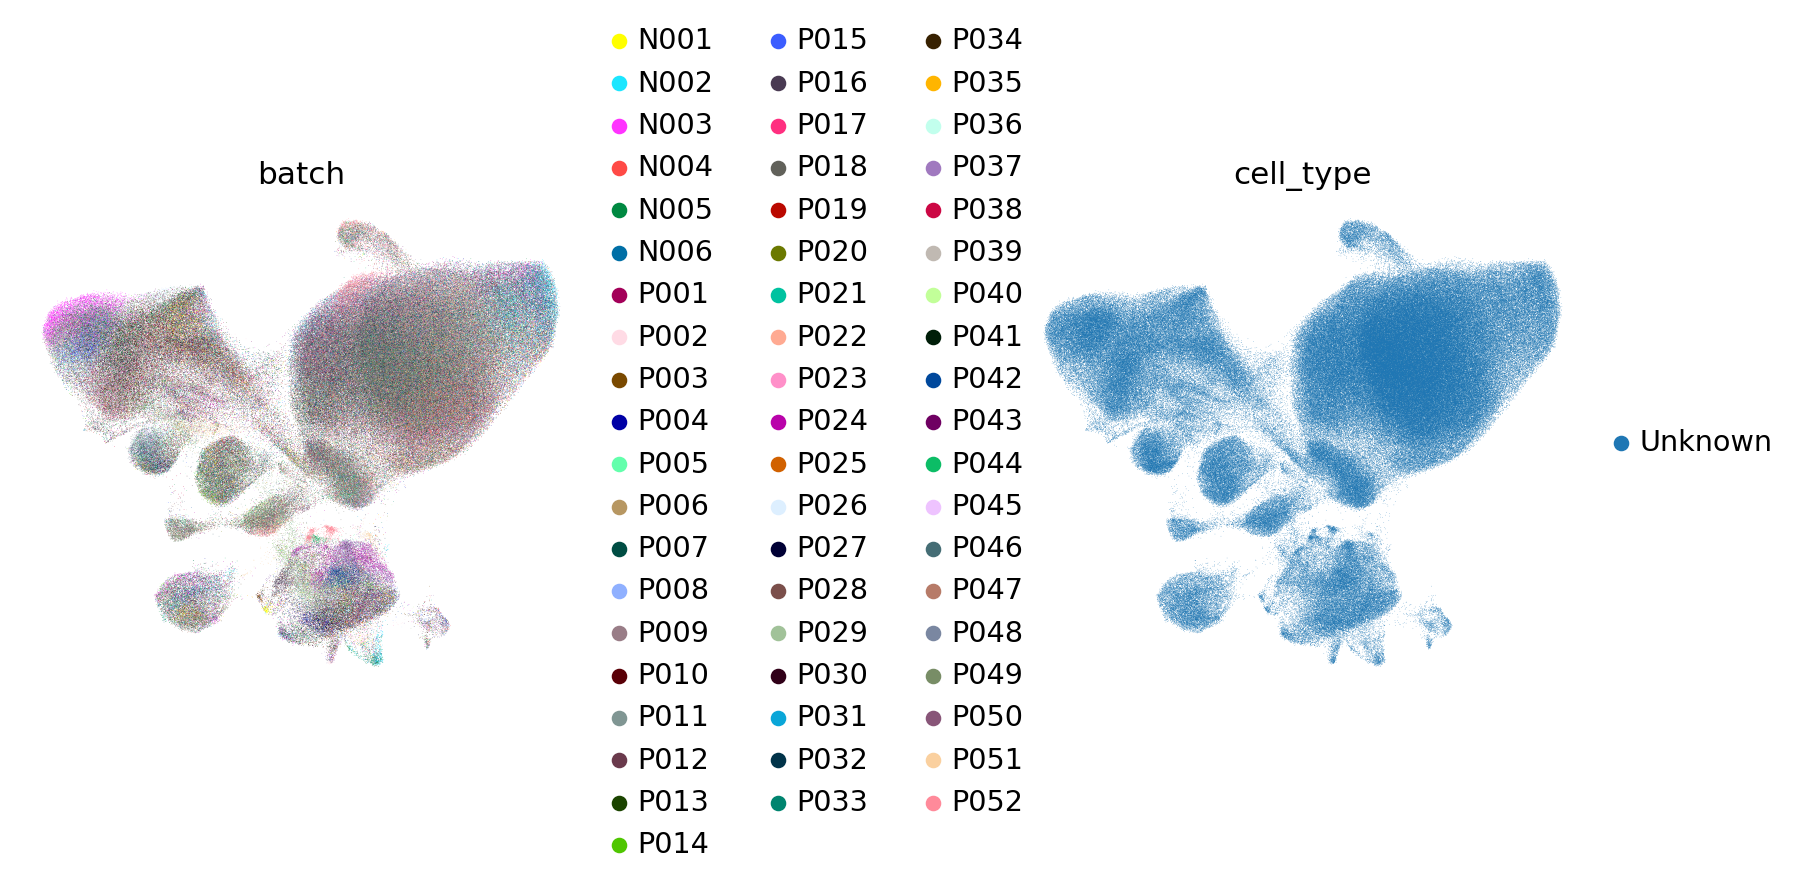

In [71]:
sc.pp.neighbors(query_latent)
sc.tl.leiden(query_latent)
sc.tl.umap(query_latent)
plt.figure()
sc.pl.umap(
    query_latent,
    color=["batch", "cell_type"],
    frameon=False,
    wspace=0.6,
)

In [72]:
query_latent.obs['predictions'] = model.predict()

In [79]:
target_adata

AnnData object with n_obs × n_vars = 488236 × 33336
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'assigned_cell_type', 'Patient Number_x', 'Group_x', 'Sex_x', 'Age （years）_x', 'Current or former smoking_x', 'Cancer history_x', 'Tumor location_x', 'Tumor size（cm）_x', 'Pathology_x', 'Histological subtype_x', 'T stage_x', 'N stage_x', 'M stage_x', 'Pathological stage_x', 'Patient Number_y', 'Group_y', 'Sex_y', 'Age （years）_y', 'Current or former smoking_y', 'Cancer history_y', 'Tumor location_y', 'Tumor size（cm）_y', 'Pathology_y', 'Histological subtype_y', 'T stage_y', 'N stage_y', 'M stage_y', 'Pathological stage_y', 'cell_type_tumor'
    var: 'features'
    obsm: 'X_tsne', 'X_umap'
    layers: 'data'

In [80]:
query_latent.obs['assigned_cell_type'] = target_adata.obs['assigned_cell_type']

/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


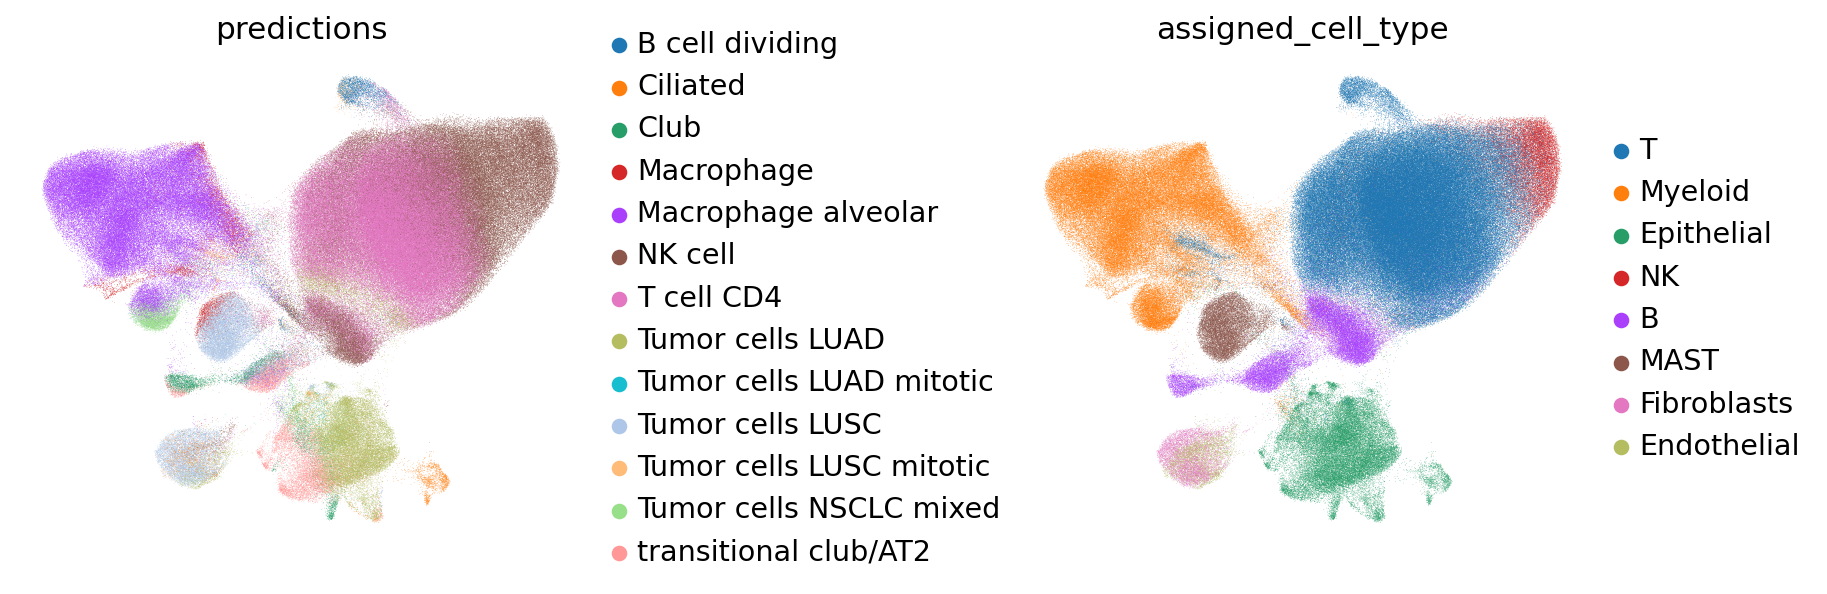

In [81]:
sc.pl.umap(
    query_latent,
    color=["predictions",'assigned_cell_type'],
    frameon=False,
    wspace=0.6,
)

## Predictions versus ref types

In [119]:
adata_ref = sc.read_h5ad(f'{ref_path}/hvg_embed.h5ad')

In [121]:
query_latent.obs['ref_or_query'] = "query"
adata_ref.obs['ref_or_query'] = "ref"
combined_emb = adata_ref.concatenate(query_latent, index_unique=None)

/tmp/ipykernel_4770/3470043735.py:3: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  combined_emb = ref_latent.concatenate(query_latent, index_unique=None)
/usr/local/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/usr/local/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [122]:
sc.pp.neighbors(combined_emb, n_neighbors=30)
sc.tl.umap(combined_emb)

In [123]:
combined_emb

AnnData object with n_obs × n_vars = 550744 × 20
    obs: 'cell_type', 'batch', 'leiden', 'predictions', 'ref_or_query', 'assigned_cell_type'
    uns: 'neighbors', 'umap'
    obsm: 'X_umap'
    obsp: 'distances', 'connectivities'

/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


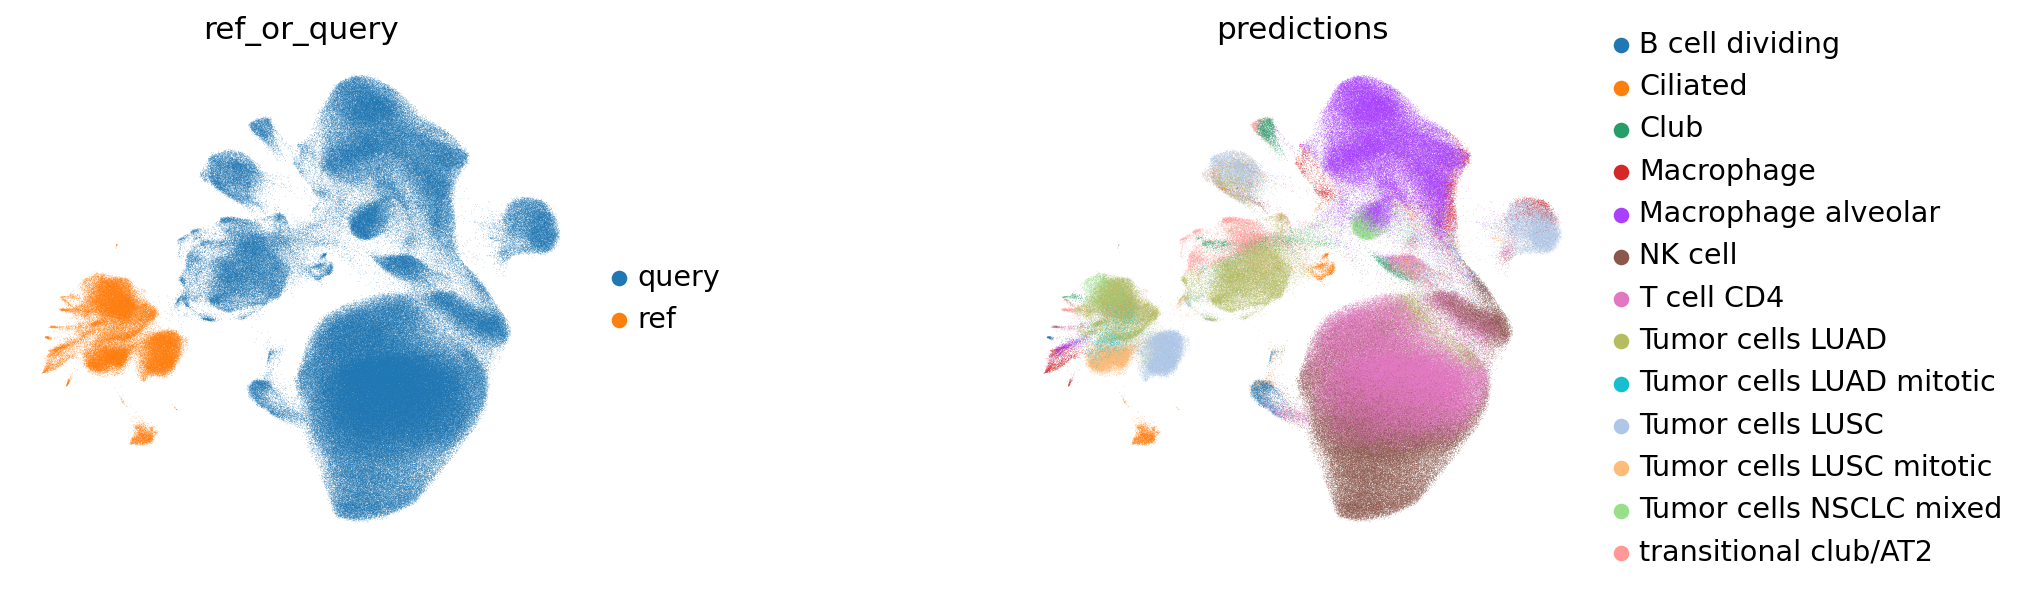

In [124]:
sc.pl.umap(
        combined_emb,
        color=['ref_or_query','predictions'],
        frameon=False,
        wspace=0.6
        )

It is very interesting to note that our embedding with VAE has our reference dataset totally separated from the query dataset. 
This could be because of batch effect correction, we corrected for sample in the ref,
but we should have corrected for dataset, to mantain the heterogeneity of samples.

Also in this particular case the ref had also normal samples and some patients without metadata.

Only after this happens does it make sense to transfer labels, a method that should be better than the classifier of the neural network.

In [46]:
#Now run the label transfer commands. Note that this might take quite a while if you have a large query dataset! For our small test dataset, it should not take long.

knn_transformer = sca.utils.knn.weighted_knn_trainer(
    train_adata=adata_ref,
    train_adata_emb="X",
    n_neighbors=50,
)

Weighted KNN with n_neighbors = 50 ... 

In [47]:
%%time

labels, uncert = sca.utils.knn.weighted_knn_transfer(
    query_adata=query_latent,
    query_adata_emb="X", # location of our joint embedding
    label_keys="cell_type",
    knn_model=knn_transformer
    )

finished!
CPU times: user 4min 31s, sys: 1.24 s, total: 4min 32s
Wall time: 43.6 s


With the commands above, we labeled every cell from the query. However, some cells might have high label transfer uncertainty.
It is useful to set those to “unknown” instead of giving them a cell type label. 
This will help highlight cell types/states that are new (i.e. not present in the reference) and possible interesting, they’re worth taking a careful look at!

This uncertainty threshold limits the false positive rate to <0.5 (as per Sikkema et al., bioRxiv 2022)

With the commands above, we labeled every cell from the query. However, some cells might have high label transfer uncertainty. It is useful to set those to “unknown” instead of giving them a cell type label. This will help highlight cell types/states that are new (i.e. not present in the reference) and possible interesting, they’re worth taking a careful look at!

This uncertainty threshold limits the false positive rate to <0.5 (as per Sikkema et al., bioRxiv 2022)

In [48]:
uncertainty_threshold = 0.2

In [49]:
labels.rename(columns={f'Level_{lev}':f'Level_{lev}_transfered_label_unfiltered' for lev in range(1,6)},inplace=True)
uncert.rename(columns={f'Level_{lev}':f'Level_{lev}_transfer_uncert' for lev in range(1,6)},inplace=True)

combined_emb.obs = combined_emb.obs.join(labels)
combined_emb.obs = combined_emb.obs.join(uncert)

In [50]:
t_labels = [f'Level_{lev}_transfered_label_unfiltered' for lev in range(1,6)]
t_uncert = [f'Level_{lev}_transfer_uncert' for lev in range(1,6)]

Convert uncertainties to arrays

In [51]:
combined_emb.obs[t_uncert] = list(np.array(combined_emb.obs[t_uncert]))

Convert cell type labels to categoricals, and set “nan” to NaN

In [52]:
def remove_uncert_types(combined_emb):
    import pandas as pd
    t_labels = [f'Level_{lev}_transfered_label_unfiltered' for lev in range(1,6)]
    t_uncert = [f'Level_{lev}_transfer_uncert' for lev in range(1,6)]
    
    combined_emb.obs[t_uncert] = list(np.array(combined_emb.obs[t_uncert]))

    for col, uncert in zip(t_labels,t_uncert):
        filtered_colname = col.replace('_unfiltered','')
        # too high uncertainty levels => set to "Unknown"
        combined_emb.obs[filtered_colname] = combined_emb.obs[col]
        combined_emb.obs[filtered_colname] = combined_emb.obs[filtered_colname].astype('str')
        combined_emb.obs[filtered_colname].mask(
            combined_emb.obs[uncert] > uncertainty_threshold,
            'Unknown',
            inplace = True)

        # convert to categorical:
        combined_emb.obs[col] = pd.Categorical(combined_emb.obs[col])
        combined_emb.obs[filtered_colname] = pd.Categorical(combined_emb.obs[filtered_colname])
        # then replace "nan" with NaN (that makes colors better in umap)
        combined_emb.obs[col].replace('nan',np.nan,inplace=True)
        combined_emb.obs[filtered_colname].replace('nan',np.nan,inplace=True)
    return combined_emb

In [53]:
remove_uncert_types(combined_emb)

AnnData object with n_obs × n_vars = 636831 × 30
    obs: 'sample', 'study_long', 'study', 'last_author_PI', 'subject_ID', 'sex', 'ethnicity', 'mixed_ethnicity', 'smoking_status', 'BMI', 'condition', 'subject_type', 'sample_type', 'single_cell_platform', "3'_or_5'", 'sequencing_platform', 'cell_ranger_version', 'fresh_or_frozen', 'dataset', 'anatomical_region_level_1', 'anatomical_region_level_2', 'anatomical_region_level_3', 'anatomical_region_highest_res', 'age', 'ann_highest_res', 'n_genes', 'log10_total_counts', 'mito_frac', 'ribo_frac', 'original_ann_level_1', 'original_ann_level_2', 'original_ann_level_3', 'original_ann_level_4', 'original_ann_level_5', 'scanvi_label', 'leiden_1', 'leiden_2', 'leiden_3', 'anatomical_region_ccf_score', 'entropy_study_leiden_3', 'entropy_dataset_leiden_3', 'entropy_subject_ID_leiden_3', 'entropy_original_ann_level_1_leiden_3', 'entropy_original_ann_level_2_clean_leiden_3', 'entropy_original_ann_level_3_clean_leiden_3', 'entropy_original_ann_level_4

Let’s take a look at the percentage of cells set to “unknown” after our filtering:

In [54]:
print(f'Percentage of unknown per level, with uncertainty_threshold={uncertainty_threshold}:')
for level in range(1,6):
    print(f"Level {level}: {np.round(sum(combined_emb.obs[f'Level_{level}_transfered_label'] =='Unknown')/adata_query.n_obs*100,2)}%")



Percentage of unknown per level, with uncertainty_threshold=0.2:
Level 1: 2.83%
Level 2: 8.57%
Level 3: 24.4%
Level 4: 33.84%
Level 5: 35.85%


## Save predictions

In [74]:
adata_query.obs['cell_type_tumor'] = query_latent.obs['predictions']

In [75]:
adata_query.obs.to_csv(f'{backup_dir}/{id_}_predicted.csv')

In [115]:
query_latent.obs['predictions'].value_counts()

T cell CD4                  185409
NK cell                     112654
Macrophage alveolar          91307
Tumor cells LUAD             32817
Tumor cells LUSC             22809
transitional club/AT2        13614
Tumor cells NSCLC mixed       7873
Macrophage                    6382
Club                          4882
B cell dividing               3751
Tumor cells LUSC mitotic      2955
Ciliated                      2768
Tumor cells LUAD mitotic      1015
Name: predictions, dtype: int64